| [$\leftarrow$ 2. Linear Regression 2 ](n2_linear_regression_2.ipynb) | [4. Linear and Polynomial Regression $\rightarrow$](n4_linear_and_polynomial_regression.ipynb) |
| :-----------------------------------------------------------------: | :---------------------------------------------------------------: |

<hr>

### 3. **Polynomial Regression**

#### 3.1. **Creating the model**

On this model, we will use just one feature to predict the target variable. The feature used is the 'Weight' variable, which seems to have a non-linear relationship with the 'Width' variable.


In [1]:
# Append the path to useful directories
import sys
sys.path.append('../my_functions')

# Packages needed
from download_dataset import download_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Download and extract the dataset
fishcatch = download_dataset(data_file='fishcatch', extension='.tar.xz')

# Quick peek at the data
df = pd.read_csv(fishcatch)
df.head(3).style.background_gradient(cmap='viridis')

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.000000,23.200000,25.400000,30.000000,11.520000,4.020000
1,Bream,290.000000,24.000000,26.300000,31.200000,12.480000,4.305600
2,Bream,340.000000,23.900000,26.500000,31.100000,12.377800,4.696100


In [2]:
# Splitting the dataset into feature and target variable
X = df['Weight']
y = df['Width']

We then use PolynomialFeatures to generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree, in this first case, 2.

In [3]:
# PolynomialFeatures (preprocessing)
from sklearn.preprocessing import PolynomialFeatures

# Transforming the feature to the desired degree
poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X.values.reshape(-1, 1))

# Quick peek at the transformed feature
X = pd.DataFrame(X, columns=[f'Weight^{i}' for i in range(X.shape[1])])
X.head(3).style.background_gradient(cmap='viridis')

,Weight^0,Weight^1,Weight^2
0,1.000000,242.000000,58564.000000
1,1.000000,290.000000,84100.000000
2,1.000000,340.000000,115600.000000


This basically means that now we have three columns: the original 'Weight' column, the 'Weight' column squared and a column of ones, which is the intercept.

In [4]:
# Split the dataset into training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [5]:
# Linear model to fit the polynomial features
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [6]:
# Training R2 score
train_r2 = lr.score(X_train, y_train)
print(f'Training R²: {train_r2:.3f}')

Training R²: 0.901


In [7]:
# Predicting the model
y_pred = lr.predict(X_test)
y_pred

array([2.79677666, 2.28268616, 3.68887447, 4.15422108, 3.3357194 ,
       6.98603016, 2.23018202, 3.54968891, 3.60569537, 7.10793846,
       6.08859626, 6.98603016, 5.89117596, 3.3357194 , 6.2687127 ,
       6.85565511, 6.98603016, 3.81177431, 3.85896306, 6.2687127 ,
       2.25482863, 5.93204433, 5.44442377, 5.44442377, 6.91814491,
       7.08670507, 3.47905789, 4.15422108, 2.22771393, 2.25400808,
       5.49221369, 2.73467924])

In [8]:
# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

Mean Squared Error: 0.43645912385487384
Root Mean Squared Error: 0.6606505308064725
Mean Absolute Error: 0.552790892741206
R2 Score: 0.8756130321661089


In [9]:
# Save the results to a csv file
from save_results import save_results
save_results(mse, mae, r2, rmse, train_r2, 'Polynomial Regression (n=2): Weight vs Width')

Results saved successfully to "results.csv".


#### 3.2 **Visualizing the model**

In [10]:
# Turning the predictions into a DataFrame
# The index is the same as the testing set because 
# we want to compare the predictions with the actual values
y_pred = pd.DataFrame(y_pred, index=X_test.index, columns=['Predicted Width'])
y_pred.head(3).style.background_gradient(cmap='viridis')

,Predicted Width
78,2.796777
155,2.282686
128,3.688874


In [11]:
# Joining the predictions with the actual values and sorting by the feature
df_plot = y_test.to_frame().join(y_pred).join(X_test['Weight^1']).sort_values(by='Weight^1')
df_plot.head(3).style.background_gradient(cmap='viridis')

,Width,Predicted Width,Weight^1
145,1.047600,2.227714,6.700000
147,1.148400,2.230182,7.000000
152,1.165900,2.254008,9.900000


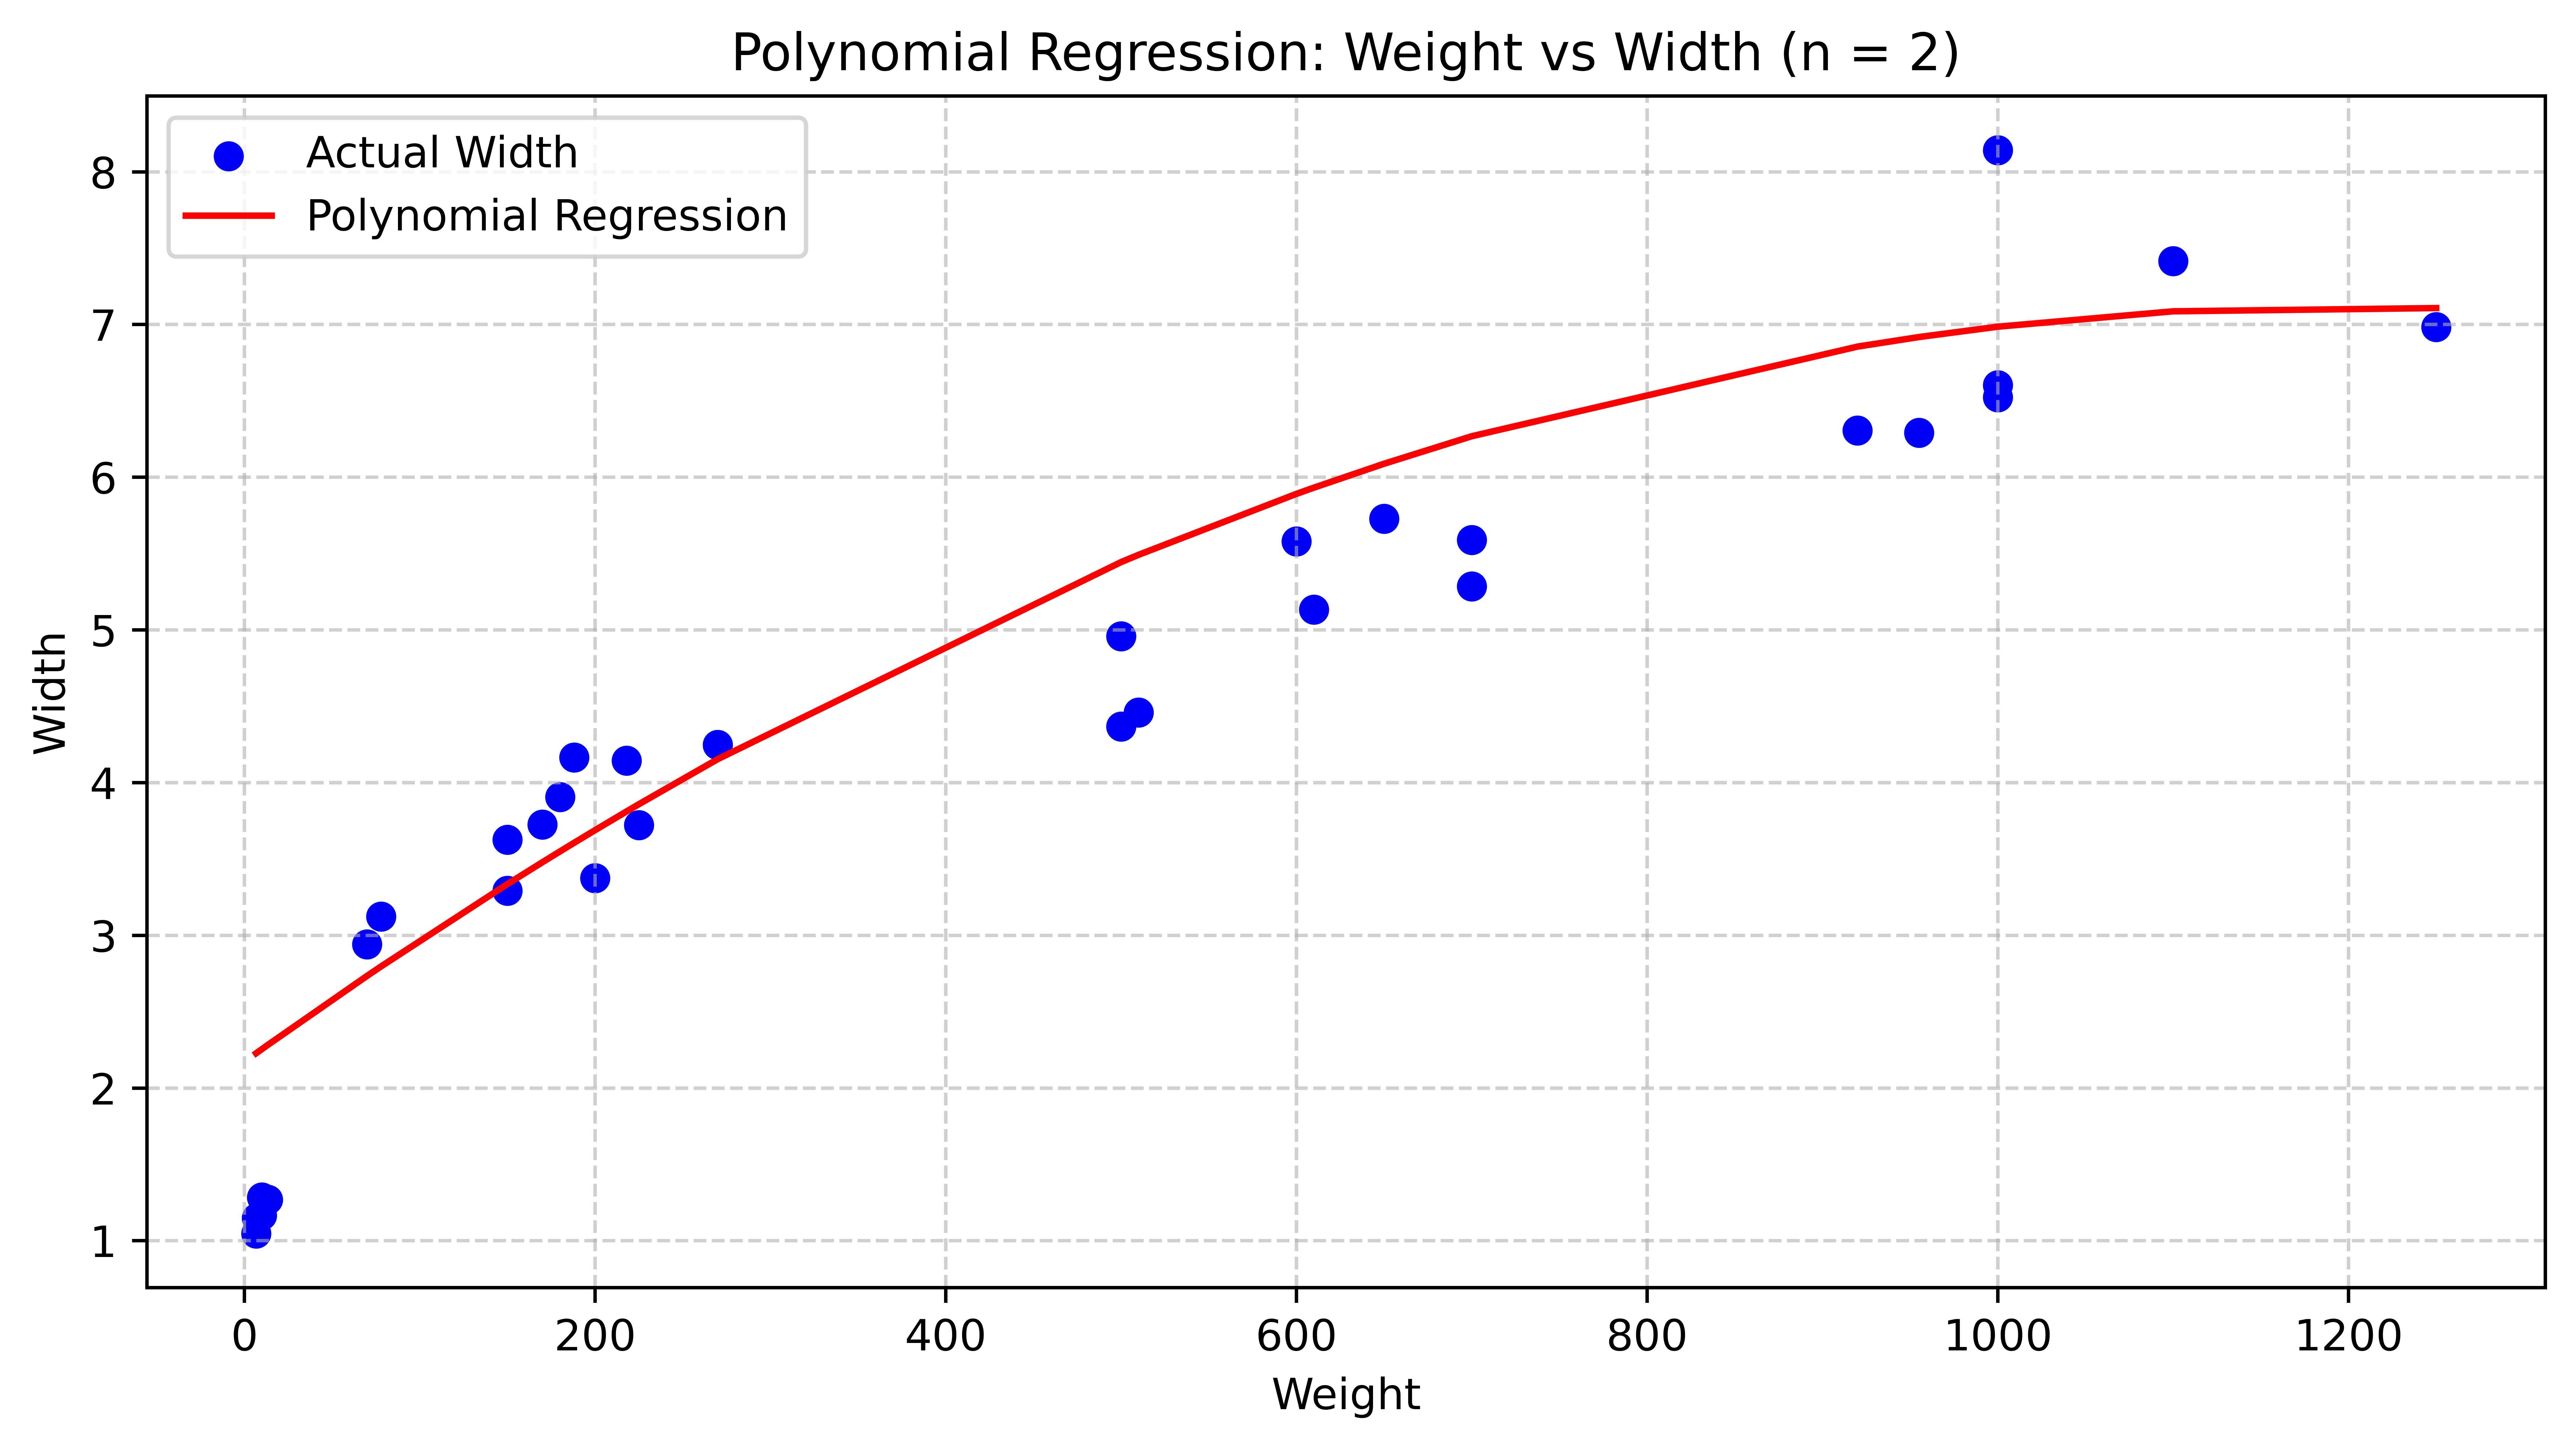

In [12]:
from plot_regression import plot_regression

plot_regression(
    X_test = df_plot['Weight^1'],
    y_test = df_plot['Width'],
    y_pred = df_plot['Predicted Width'],
    title = 'Weight vs Width (n = 2)',
    regression_type = 'Polynomial',
    xlabel = 'Weight',
    ylabel = 'Width',
)

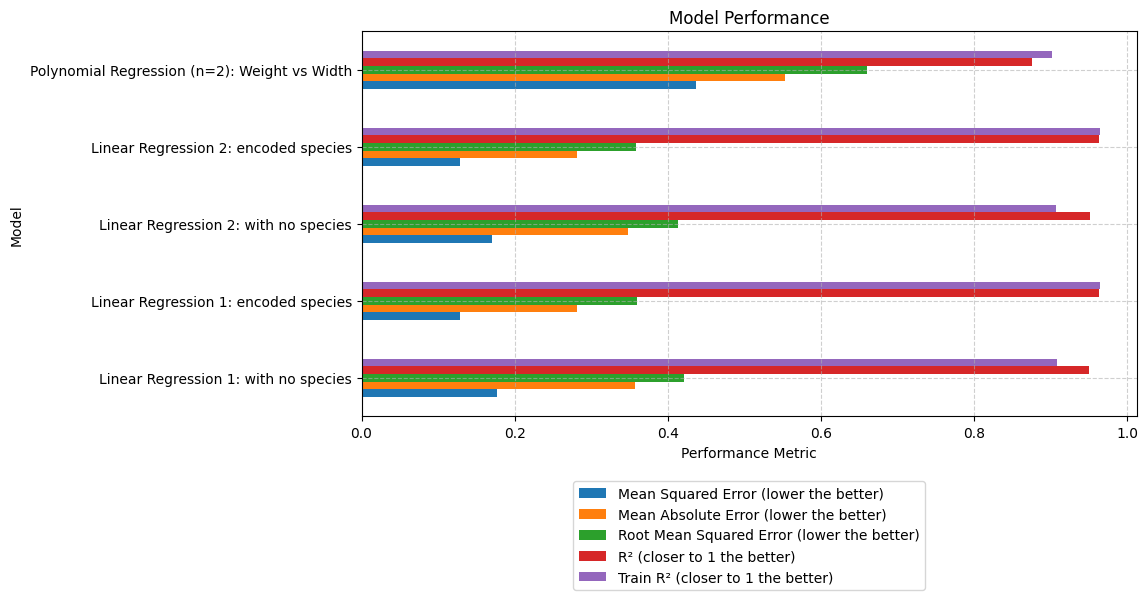

In [13]:
from save_results import plot_results
plot_results()

#### 3.3. **Implementing Pipeline**

This way it's possible to automate the process of transforming the features and fitting the model.

Let's use it to compare the results of different degrees of polynomial features.

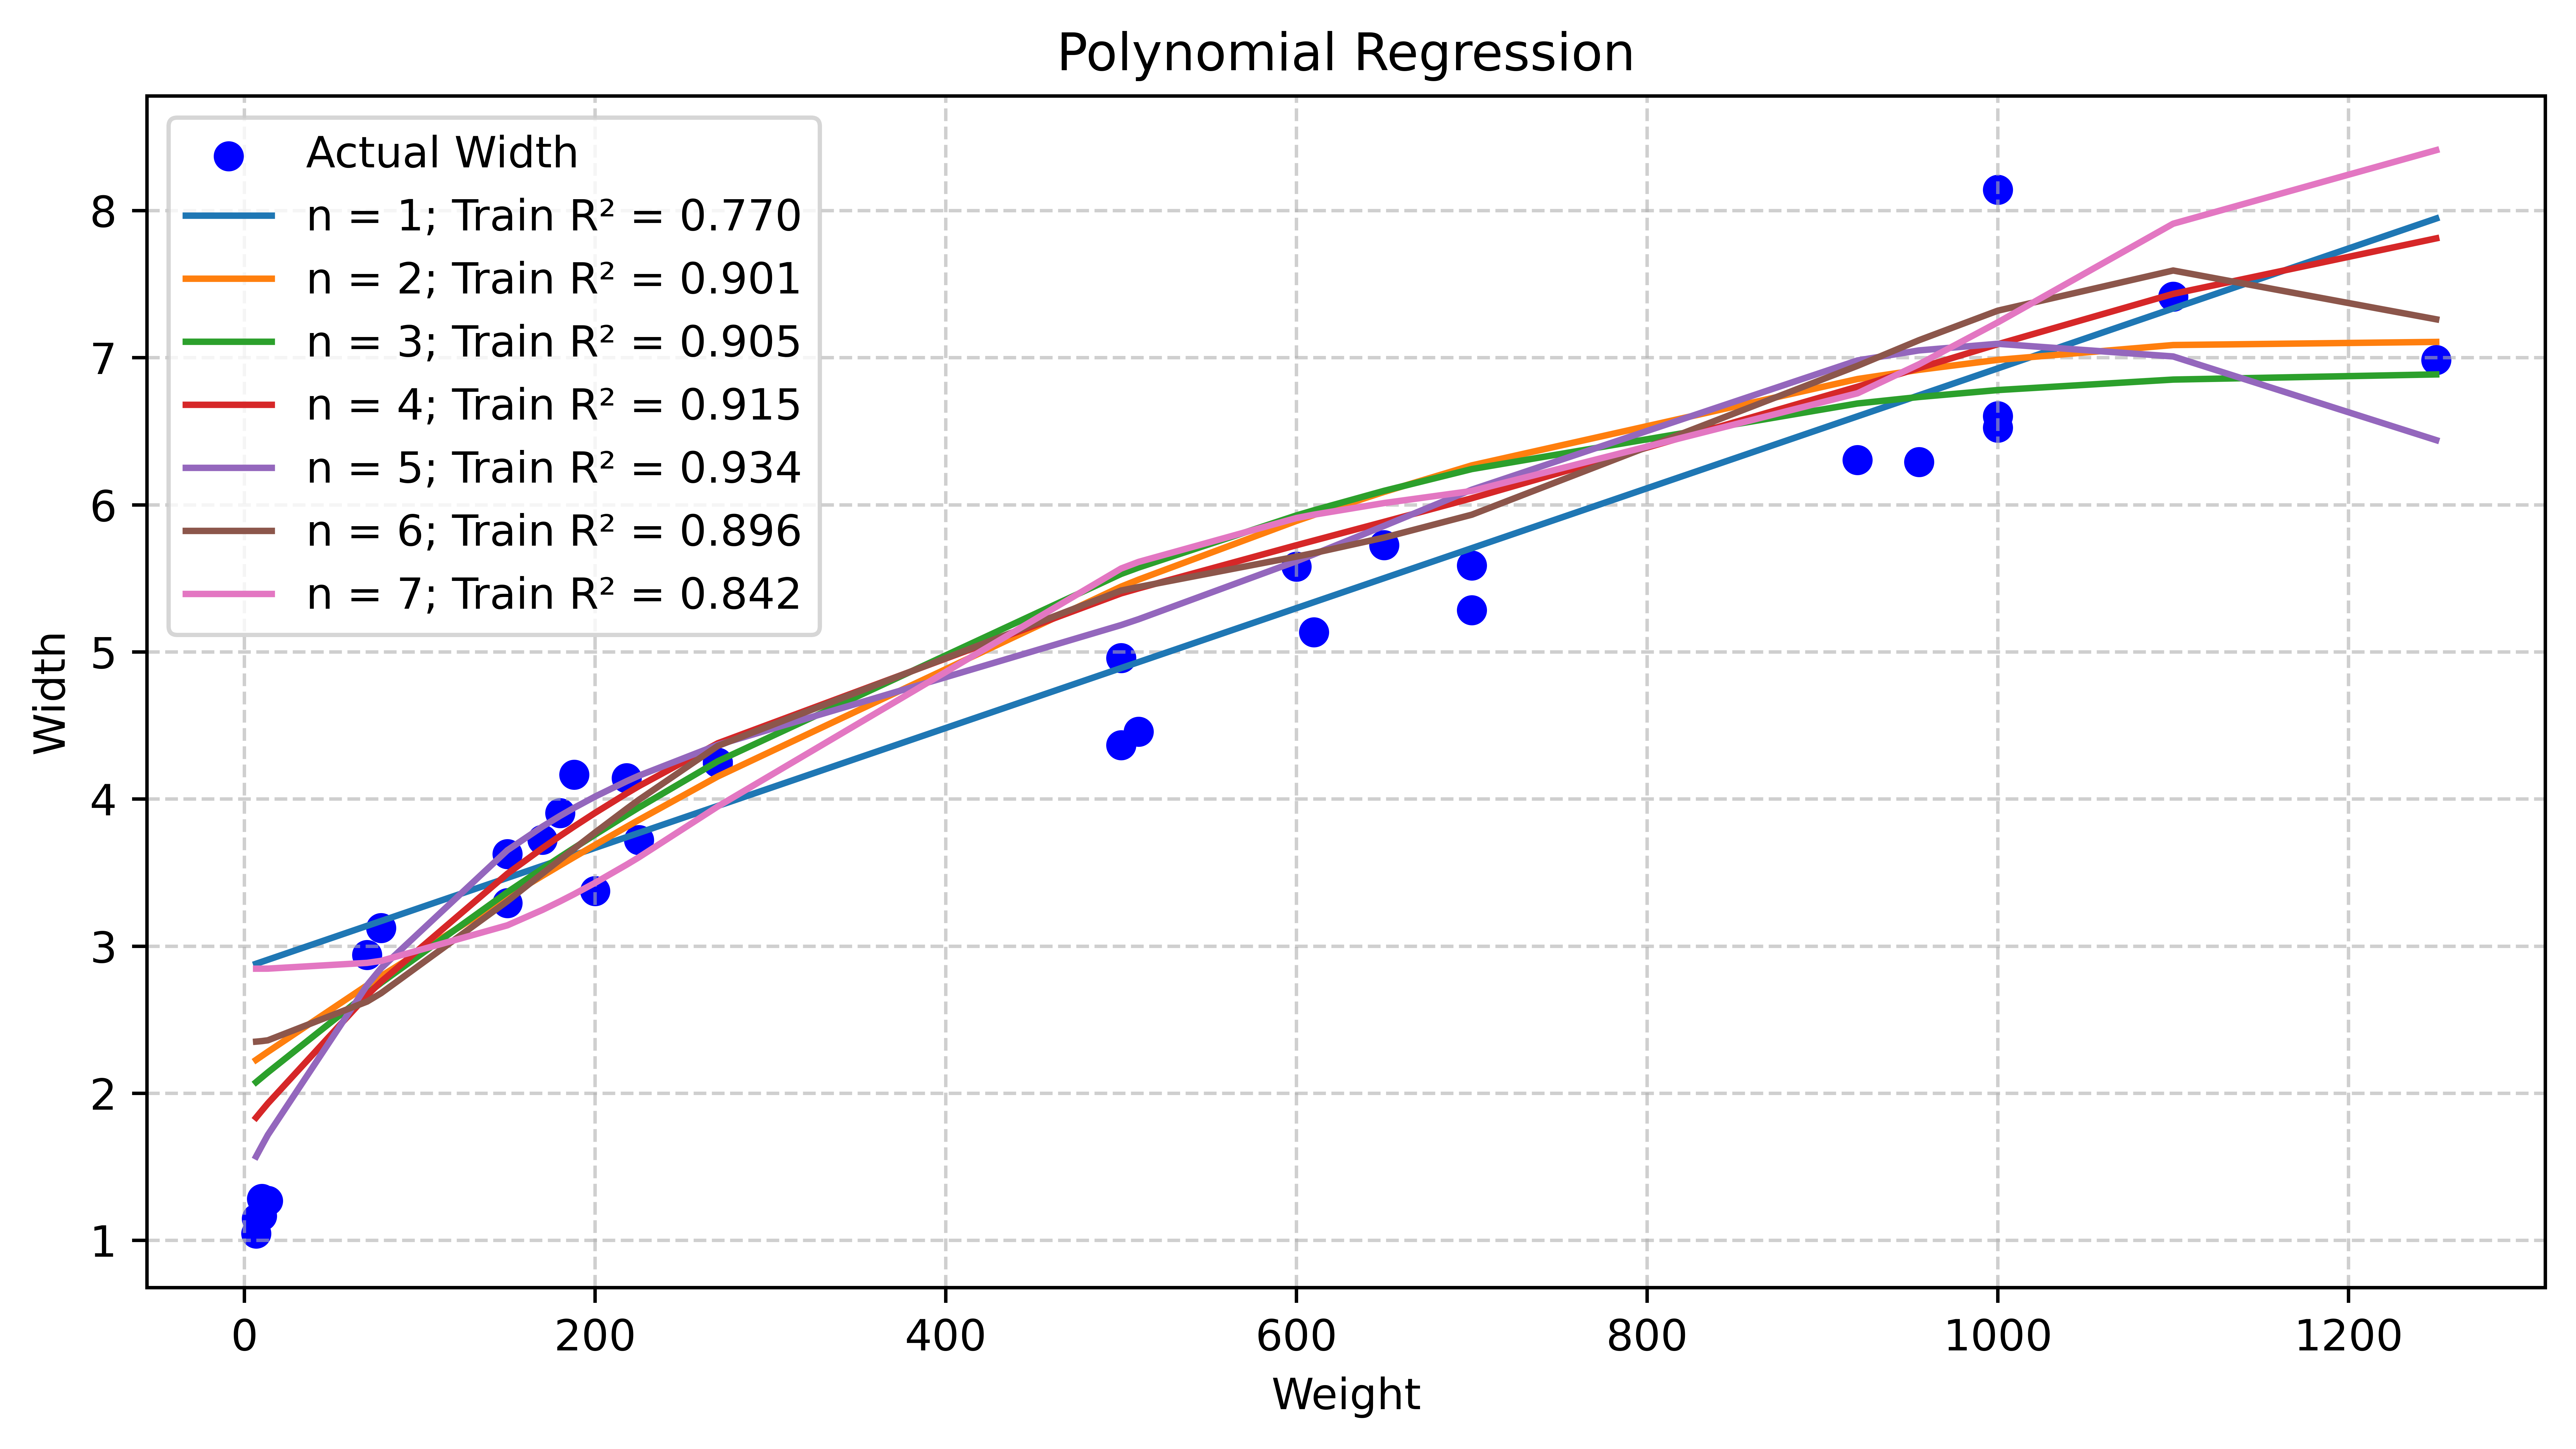

In [14]:
from sklearn.pipeline import make_pipeline

# Reassigning the feature
X = df[['Weight']]

fig, ax = plt.subplots(figsize=(10, 5), dpi=1080)
ax.scatter(df_plot['Weight^1'], df_plot['Width'], color='blue', label='Actual Width')
ax.set_xlabel('Weight')
ax.set_ylabel('Width')
ax.set_title(f'Polynomial Regression')
ax.grid(True, linestyle='--', alpha=0.6)

# Split the dataset into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Loop through different degrees
for n in range(1, 8):
    # Model fitting and prediction
    model = make_pipeline(PolynomialFeatures(degree=n), LinearRegression())
    model.fit(X_train, y_train)
    # Sort X_test
    X_test_sorted = X_test.sort_values(by='Weight')
    # Predict
    y_pred = model.predict(X_test_sorted)
    # Metrics
    train_r2 = model.score(X_train, y_train)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    save_results(mse, mae, r2, rmse, train_r2, f'Polynomial Regression Pipeline: n = {n}', confirm=False)
    # Plotting each prediction
    ax.plot(X_test_sorted, y_pred, label=f'n = {n}; Train R² = {train_r2:.3f}')

ax.legend()
plt.show()

The model is better when n = 5. On the next notebook, this model will be combined with all the other numeric variables, making a global model.

#### 3.4. Comparison

In [15]:
# FIXME: The results saved from the loop are on another scale
# TODO: Implement Standard Scaler

# from save_results import plot_results
# plot_results()

### <hr>

| [$\leftarrow$ 2. Linear Regression 2 ](n2_linear_regression_2.ipynb) | [4. Linear and Polynomial Regression $\rightarrow$](n4_linear_and_polynomial_regression.ipynb) |
| :-----------------------------------------------------------------: | :---------------------------------------------------------------: |
